In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import arviz as az
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import pymc as pm

from utils.model import inference_model

In [42]:
data = pd.read_csv("data_clean.csv")

In [43]:
data

,Child.ID,Visit,Ethnicity,Diagnosis,Gender,Age,ADOS,MullenRaw,ExpressiveLangRaw,Socialization,...,CHI_MLU,CHI_LUstd,types_MOT,types_CHI,tokens_MOT,tokens_CHI,ADOS1,verbalIQ1,nonVerbalIQ1,Socialization1
0,1,1,White,TD,M,18.07,15.0,NaN,NaN,104.0,...,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,104
1,2,1,White,TD,M,19.80,0.0,28.0,14.0,108.0,...,1.252252,0.473980,378.0,14.0,1835.0,139.0,0,14.0,28.0,108
2,2,2,White,TD,M,23.93,NaN,NaN,NaN,110.0,...,1.013605,0.115846,403.0,18.0,2160.0,148.0,0,14.0,28.0,108
3,2,3,White,TD,M,27.70,NaN,NaN,NaN,109.0,...,1.556886,0.747088,455.0,97.0,2149.0,255.0,0,14.0,28.0,108
4,2,4,White,TD,M,32.90,NaN,33.0,NaN,102.0,...,2.251572,1.578027,533.0,133.0,2260.0,321.0,0,14.0,28.0,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,66,2,White,ASD,M,46.77,NaN,NaN,NaN,79.0,...,1.099099,0.394138,250.0,48.0,1205.0,356.0,15,16.0,27.0,79
368,66,3,White,ASD,M,50.63,NaN,NaN,NaN,94.0,...,1.582857,1.137789,313.0,70.0,1618.0,254.0,15,16.0,27.0,79
369,66,4,White,ASD,M,54.13,NaN,28.0,NaN,92.0,...,1.320423,0.847202,348.0,61.0,1644.0,334.0,15,16.0,27.0,79
370,66,5,White,ASD,M,58.57,15.0,NaN,NaN,95.0,...,1.668896,1.490461,320.0,122.0,1527.0,511.0,15,16.0,27.0,79


In [26]:
RANDOM_SEED = 6969

In [41]:
data = pd.read_csv("data_clean.csv")
data = data[["CHI_MLU", "Diagnosis", "Visit"]].rename(columns={
    "CHI_MLU": "child_mlu",
    "Diagnosis": "diagnosis",
    "Visit": "visit",
    "Child.ID": "child_id"
}).dropna(axis="index")
diag_values, diag_uniques = data.diagnosis.factorize()
data = data.assign(diagnosis=diag_values)

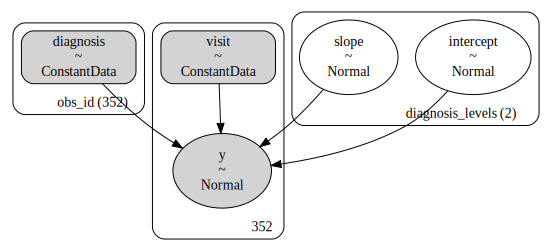

In [29]:
with model:
    graph = pm.model_to_graphviz(model)
graph

In [30]:
prior_pred_check = pm.sample_prior_predictive(
    samples=100,
    random_seed=RANDOM_SEED,
    model=model
)
idata = prior_pred_check.copy()
prior_predictive = inferencedata_to_df(prior_pred_check)
fig = px.box(
    prior_predictive,
    x=prior_predictive.visit.map(str),
    y="y",
    color=prior_predictive.diagnosis.map(dict(enumerate(diag_uniques)))
).update_layout(
    xaxis_title="Visit",
    yaxis_title="MLU",
    title="Prior predictive check of the model"
)
fig

<AxesSubplot: xlabel='y / y'>

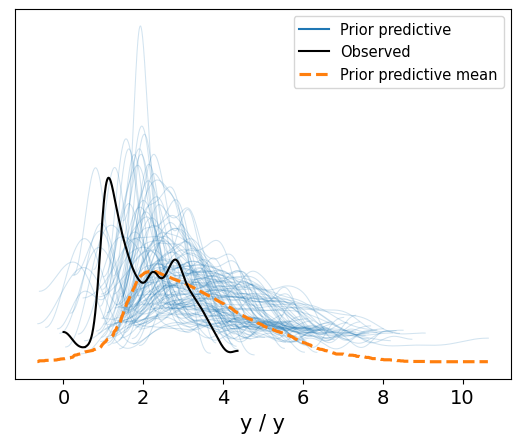

In [31]:
az.plot_ppc(prior_pred_check, group="prior")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


array([[<AxesSubplot: title={'center': 'intercept'}>,
        <AxesSubplot: title={'center': 'intercept'}>],
       [<AxesSubplot: title={'center': 'slope'}>,
        <AxesSubplot: title={'center': 'slope'}>]], dtype=object)

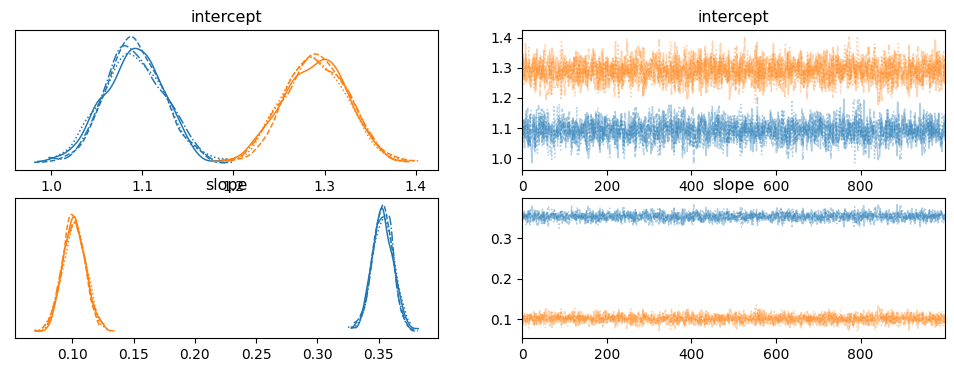

In [32]:
posterior_sample = pm.sample(1000, model=model)
idata.extend(posterior_sample)
az.plot_trace(posterior_sample)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.


<AxesSubplot: xlabel='y / y'>

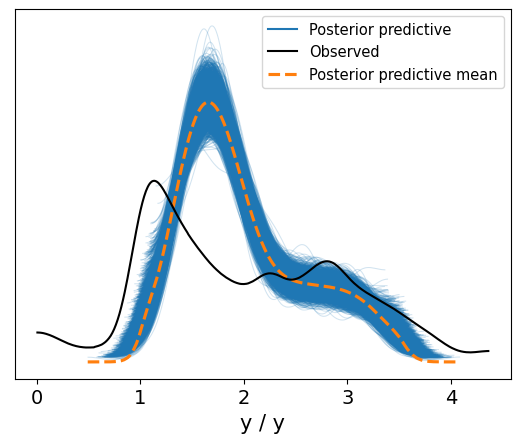

In [37]:
with model:
    pp_check = pm.sample_posterior_predictive(
        pm.sample(1000, tune=2000),
    )
idata.extend(pp_check)
az.plot_ppc(pp_check)

In [38]:
post_pred = inferencedata_to_df(pp_check)
post_pred = post_pred.rename(columns={
    "y_pred": "prediction",
    "y": "observed",
}).melt(
    id_vars=["diagnosis", "visit"],
    value_vars=["prediction", "observed"],
    var_name="source"
)

In [39]:
vis_df = post_pred.sample(50_000)
fig = px.box(
    vis_df,
    x=vis_df.visit.map(str),
    y="value",
    color="source",
    facet_col=vis_df.diagnosis.map(dict(enumerate(diag_uniques)))
).update_layout(
    xaxis_title="Visit",
    yaxis_title="MLU",
).update_xaxes(categoryorder='array', categoryarray=list(range(1,7)))
fig #.write_image("post_pred.png")

array([[<AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: xlabel='intercept\nTD'>],
       [<AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: xlabel='intercept\nASD'>],
       [<AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: xlabel='slope\nTD'>],
       [<AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: xlabel='slope\nASD'>]], dtype=object)

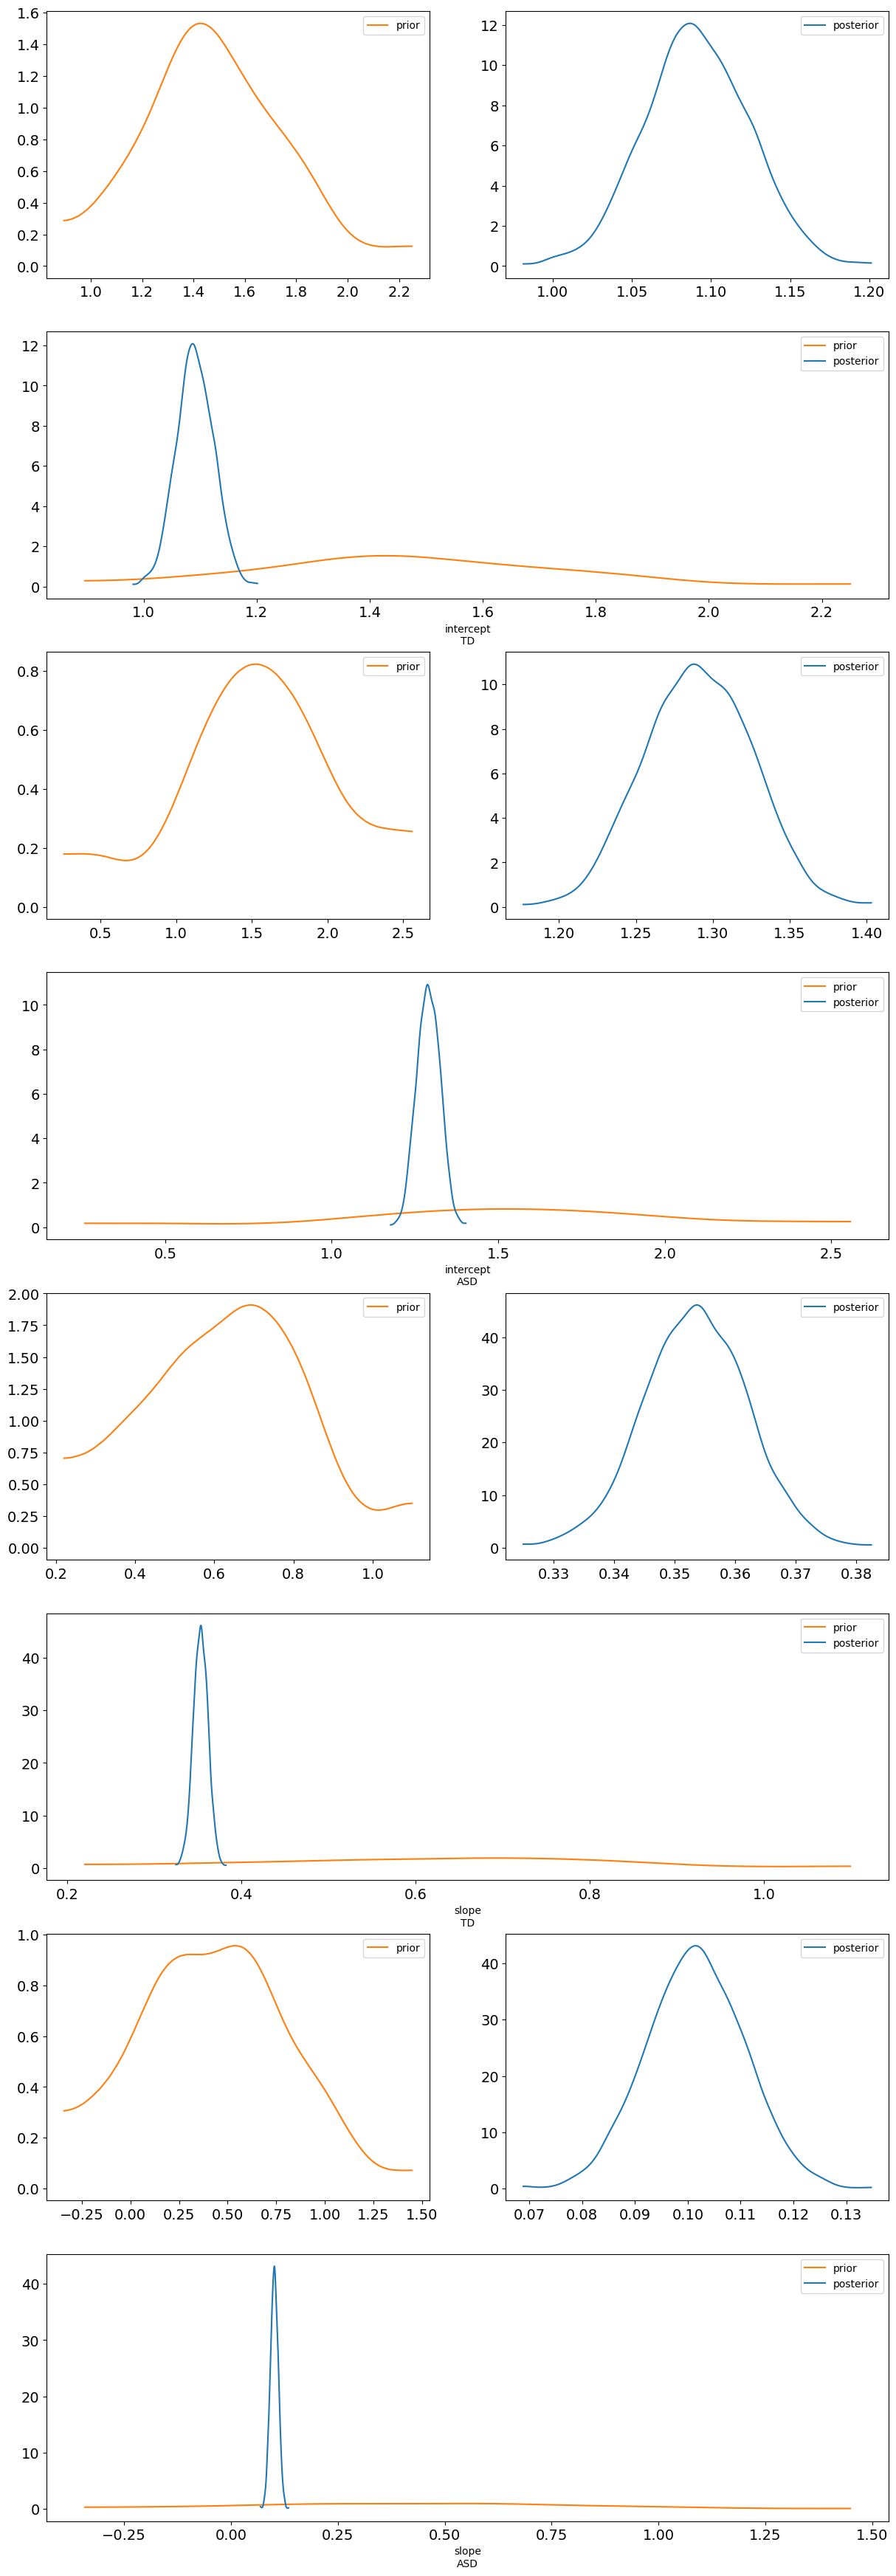

In [40]:
az.plot_dist_comparison(idata, kind="latent")

In [20]:
trace[0]

KeyError: 0